<a href="https://colab.research.google.com/github/capitaineoblivious/Grab_AIforSEA/blob/master/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRAB AI for SEA
## Traffic Management

This notebook summarizes the model building process I came up with

# Necessary packages
Let us first make sure the necessary packages are installed. You can skip this cell if all the packages are already installed


In [2]:
!pip install python-geohash
!pip install pandas
!pip install tensorflow
!pip install numpy
!pip install matplotlib

  Stored in directory: /root/.cache/pip/wheels/b5/64/5a/6a286481fc7c2a698d2f297d4c90af19946be430b23eba9a33
Successfully built python-geohash


We import all the necessary modules

In [3]:
import sys
import os

import pandas as pd
import numpy as np
import random

import geohash

import folium
from folium import plugins
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
tf.enable_eager_execution()

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Data preparation

We load the data on a pandas DataFrame and prepare it for training our model

In [4]:
dataset_link = 'https://s3-ap-southeast-1.amazonaws.com/grab-aiforsea-dataset/traffic-management.zip'
df = pd.read_csv(dataset_link, compression='zip', header=0, sep=',', quotechar='"')
df.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


We calculate the mean and standard deviation of latitude and longitude of each geohash on the dataframe.
This will help at a later stage to normalize the data

In [5]:
lat_long = pd.DataFrame(df['geohash6'].apply(geohash.decode).tolist(), columns=['latitude', 'longitude'])
std_lat = lat_long.latitude.unique().std()
mean_lat = lat_long.latitude.unique().mean()
std_long = lat_long.longitude.unique().std()
mean_long = lat_long.longitude.unique().mean()

print(std_lat, mean_lat, std_long, mean_long)

0.07292679591440783 -5.361328125 0.11412921417661685 90.780029296875


We now normalize the latitude and longitude

We also determine the set of all timestamps (the timestamps where no value is given are 0)

In [6]:
max_d = int(max(df.day))
all_ts = []
for d in range(1, max_d +1):
    for h in range(0, 24):
        for m in [0,15,30,45]:
            ts = str(d).zfill(2) + '-' + str(h).zfill(2) + ':' + str(m).zfill(2)
            all_ts.append(ts)

print('The first timestamp of the data set is:', all_ts[0])
print('The last timestamp of the data set is:', all_ts[-1])
print('There are %d timestamps in the dataset' %(len(all_ts)))

The first timestamp of the data set is: 01-00:00
The last timestamp of the data set is: 61-23:45
There are 5856 timestamps in the dataset


We determine all the geohashes, and the geohashes that have more than 1000 non-zeros timestamps

In [7]:
all_geo = df['geohash6'].unique().tolist()

counts = pd.DataFrame(df['geohash6'].value_counts())
counts.columns = ['count']
frequent_geo = counts[counts['count'] >= 1000].index.tolist()
rare_geo = counts[counts['count'] < 1000].index.tolist()
print('%d geohashes were filtered out' %(len(all_geo)-len(frequent_geo)))

306 geohashes were filtered out


We reformat the timestamps to a more homogeneous form and we transform into a pivot table where the columns are the geohashes and the index are the timestamps

In [0]:
def formatted(string):
    hour, minute = string.split(':')
    return hour.zfill(2) + ":" + minute.zfill(2)

def hour(string):
    hour, minute = string.split(':')
    return int(hour)

df['hour'] = df['timestamp'].apply(hour)    
df['timestamp'] = df.day.apply(lambda x: str(x).zfill(2)) + '-' + df['timestamp'].apply(formatted)

data = df.pivot(index='timestamp', columns='geohash6', values='demand')
data = data.reindex(all_ts).fillna(0)
training_data, testing_data = data.iloc[:int(0.7*len(all_ts))], data.iloc[int(0.7*len(all_ts)):]

In [9]:
data.shape

(5856, 1329)

We remove from the dataset the geohashes for which the values ressembles a white noise.
For a timeseries of length T, we consider it to be a white noise if 95% of the spikes of the autocorrelation plot falls below the treshold $2 / \sqrt{T}$.
[https://otexts.com/fpp2/wn.html]


In [10]:
def autocorr1(x):
    '''numpy.corrcoef, partial'''
    corr=[np.corrcoef(x[l:],x[:-l])[0][1] for l in range(1, len(x)-2)]
    return np.array(corr)

def check_randomness(data, geohashes):
    random = []
    
    T = len(data.index)
    treshold = 2 / np.sqrt(T)
    for g in geohashes:
        x = autocorr1(data[g])
        ratio = len(x[x<treshold]) / len(x)
        if ratio > 0.95:
            random.append(g)
    return random
        
randoms = check_randomness(data, rare_geo)
good_geo = list(set(all_geo) - set(randoms))

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]




We now define a helper function that will generate samples to be trained on.

The function takes in 5 parameters:
1. data is the pandas dataframe that we just polished above
2. geohashes is the list of geohashes that we consider for forecasting
3. Tx is the length of the subsequence
4. m is the number of samples per geohash
5. size is the number of geohashes to be sampled from the list of geohashes

It returns two numpy tensors:
1. A is the training data of dimensions (m * size, Tx, 29)
2. B is the target data of dimensions (m * size, Tx, 1)

The 29 features are:
- demand
- one_hot vector of length 24 representing the 24 hours of a day. The value of 1 is set according to the timestamp
- the four values of latitude, longitude and their squared value





In [11]:
def sample_subsequences(data, geohashes, Tx, m, size):
    geohashes = np.random.choice(geohashes, size=size)
    
    Tmax = len(data)
    dim = m * len(geohashes) 
    X = np.zeros((dim, Tx, 29)) # 29 features : demand, one hot vector of hours (24), long, lat, long2, lat2 
    Y = np.zeros((dim, Tx, 1)) # 1 feature : demand at T + 1

    count = 0
    for ghash in geohashes:
        for i in range(m):
            start = np.random.randint(1, Tmax - Tx - 1)
            end = start+Tx

            sample = data[ghash]
            ts = sample.iloc[start:end].index
            target = sample.iloc[start+1:end+1].values
            sample = sample.iloc[start:end].values
            
            lat, long = geohash.decode(ghash)
            lat = (lat - mean_lat) / std_lat
            long = (long - mean_long) / std_long
           
            matrix = np.zeros((Tx, 29))
            for j, s in enumerate(ts):
                hour = int(s.split('-')[1].split(':')[0])
                matrix[j, 0] = sample[j]
                matrix[j, hour+1] = 1
                matrix[j, 25:] = np.array([lat, long, lat**2, long**2])
            X[count] = matrix
            Y[count] = np.array(target).reshape((Tx, 1))
            count +=1
    return X,Y

A, B = sample_subsequences(training_data, good_geo, Tx=256, m=16, size=20)
A.shape

(320, 256, 29)

## Model preparation

Let us now define our model. This model is based on recurrent LSTM cells
- One cell with 256 units
- One LSTM cell of 128 units
- One LSTM cell of 64 units
- One LSTM cell of 64 units
- One Dense layer with sigmoid activation for output. The sigmoid ensures that the predicted output is between the expected range of [0, 1]

As we will use our model to make predictions we need it to be stateful, and thus the batch_size is fixed when the model is built.

In [12]:
if tf.test.is_gpu_available():
  print(' GPU acceleration available')
  rnn = tf.keras.layers.CuDNNLSTM
else:
  print(' NO GPU detected')
  rnn = tf.keras.layers.LSTM

# define model where LSTM is also output layer

def build_model(batch_size=16):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=(None, 29),batch_size=batch_size))
    model.add(rnn(256, return_sequences=True, stateful=True))
    model.add(rnn(128, return_sequences=True, stateful=True))
    model.add(rnn(64, return_sequences=True, stateful=True))
    model.add(rnn(64, return_sequences=True, stateful=True))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

model = build_model()
opt = tf.keras.optimizers.Adam(lr=0.015, beta_1=0.9, beta_2=0.999, decay=0.005)
model.compile(optimizer=opt, loss='mean_squared_error')

 GPU acceleration available


In [16]:
# Directory where the checkpoints will be saved
checkpoint_dir = ''
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)


N_LOOP = 1

for i in range(N_LOOP):
    print(i)
    A, B =  sample_subsequences(training_data, good_geo, Tx=384, m=16, size=30)
    model.reset_states()
    bo = 1 if i < N_LOOP - 1 else 1
    history = model.fit(A, B, epochs=20, verbose=bo, batch_size=16, callbacks=[checkpoint_callback])
print('done')

model.save('/content/gdrive/My Drive/Colab Notebooks/my_model.h5')

0
Epoch 1/20
480/480 [==============================] - 3s 6ms/sample - loss: 7.7841e-04
Epoch 2/20
480/480 [==============================] - 2s 4ms/sample - loss: 8.1456e-04
Epoch 3/20
480/480 [==============================] - 2s 4ms/sample - loss: 7.3875e-04
Epoch 4/20
480/480 [==============================] - 2s 4ms/sample - loss: 6.7546e-04
Epoch 5/20
480/480 [==============================] - 2s 4ms/sample - loss: 7.0187e-04
Epoch 6/20
480/480 [==============================] - 2s 4ms/sample - loss: 7.1076e-04
Epoch 7/20
480/480 [==============================] - 2s 4ms/sample - loss: 7.1980e-04
Epoch 8/20
480/480 [==============================] - 2s 4ms/sample - loss: 7.0944e-04
Epoch 9/20
480/480 [==============================] - 2s 4ms/sample - loss: 7.1526e-04
Epoch 10/20
480/480 [==============================] - 2s 4ms/sample - loss: 6.9561e-04
Epoch 11/20
480/480 [==============================] - 2s 4ms/sample - loss: 6.9474e-04
Epoch 12/20
480/480 [==================

In [0]:
AA, BB =  sample_subsequences(testing_data, good_geo, Tx=384, m=16, size=20)

In [0]:
toto = model.predict(AA)

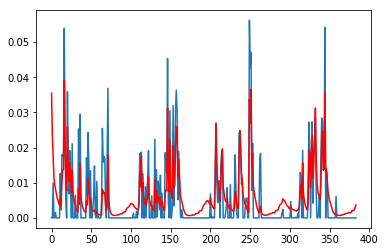

In [19]:
i=23
plt.plot(AA[i,:,0])
plt.plot(toto[i,:,0], color='red')

We reload the model with batch_size=1 for prediction

In [0]:
model2 = build_model(batch_size=1)

model2.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model2.build(tf.TensorShape([1, None, 29]))

We define the function to make predictions

In [0]:
def make_predictions(sequence, model2, Tn, Tx):
    seq = sequence.copy()
    
    pred = []
    out = None
    
    model2.reset_states()

    for i in range(Tn+Tx):
        val = seq[:,i,:].reshape((1,1,29))
        if i >= Tn:
            val[0,0,0] = out
        pred.append(val[0,0,0])
        out = model2.predict(val)
        out = tf.squeeze(out).numpy()
    
    next_5 = sequence[0,Tn:Tn+Tx,0]
    to_compare = np.array(pred[-Tx:])
    error = np.sqrt(np.sum((next_5 - to_compare)**2))
    max_relative_error = max(abs((to_compare - next_5) / to_compare))
    return pred, error, max_relative_error

In [0]:
validation_sequence, target = sample_subsequences(testing_data, good_geo, Tx=384, m=1, size=1)

predictions, error, relative_error = make_predictions(validation_sequence, model2, 20, 5)
plt.plot(predictions, color='green')
plt.plot(validation_sequence[0,0:20+5,0], color='red')
print('RMSE error: %.10f, Max Relative Error: %.10f ' %(error, relative_error*100))

We compute the average loss over 500 samples

In [0]:
rmse = []
for i in range(500):
    validation_sequence, target = sample_subsequences(testing_data, good_geo, Tx=384, m=1, size=1)

    _, error, _ = make_predictions(validation_sequence, model2, 256, 5)
    rmse.append(error)
    

print('RMSE over 2000 sequences: %.3f' %(np.array(rmse).mean()))

Let's save the model

In [0]:
model.save('/content/gdrive/My Drive/Colab Notebooks/my_model.h5')